In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"


In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

# Load raw events

In [3]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

# bkg = read_h5_file(database_path, files["SM"])
# # SM processes

# neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# print(neutral_boson.shape)
# # A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

# leptoquark = read_h5_file(database_path, files["leptoquark"])
# print(leptoquark.shape)
# # A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

# neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# print(neutral_Higgs.shape)
# # A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

# charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# print(charged_Higgs.shape)
# # A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

events = {}
for key, value in files.items():
    events[key] = read_h5_file(database_path, value)
    print(key, events[key].shape)

SM (13451915, 19, 4)
neutral_boson (55969, 19, 4)
leptoquark (340544, 19, 4)
neutral_Higgs (691283, 19, 4)
charged_Higgs (760272, 19, 4)


In [4]:
signals = [key for key in events.keys() if key != "SM"]
print(signals)

['neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs']


# Load embedding model

In [5]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]
output_dim = model_hyper_parameters["output_dim"]

embedding_model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 8}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Embed events

In [6]:
from analysis import inference

In [7]:
from data import EventDataset

In [8]:
infer_test_num = 1000000
dataloaders = {}
for key, value in events.items():
    dataloaders[key] = DataLoader(EventDataset(value[:infer_test_num]), batch_size=256, num_workers=16, prefetch_factor=5)

In [9]:
embedding_points = {}
embedding_model.load_state_dict(torch.load(os.path.join("..", "model","emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale))))
embedding_model.to(device)
for key, value in dataloaders.items():
    embedding_points[key] = inference(embedding_model, value, embed_dim=output_dim)
    print(key, embedding_points[key].shape)

100%|██████████| 3907/3907 [00:08<00:00, 442.13it/s]


SM (1000000, 8)


100%|██████████| 219/219 [00:01<00:00, 201.68it/s]


neutral_boson (55969, 8)


100%|██████████| 1331/1331 [00:03<00:00, 406.00it/s]


leptoquark (340544, 8)


100%|██████████| 2701/2701 [00:05<00:00, 452.72it/s]


neutral_Higgs (691283, 8)


100%|██████████| 2970/2970 [00:06<00:00, 453.84it/s]

charged_Higgs (760272, 8)


In [10]:
from analysis import Normalizer

In [11]:
normalizer = Normalizer(*[value for value in embedding_points.values()])

In [12]:
print(normalizer.max)
print(normalizer.min)

[195.94314575 306.04678345 169.08666992 229.35830688 275.73455811
 311.03366089 153.96336365 290.96902466]
[-262.50848389 -289.52780151 -201.62272644 -281.99453735 -297.74050903
 -282.32440186 -178.91546631 -354.94134521]


# Split embed points

In [13]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}

In [14]:
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders

In [15]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 100000

test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"

exp_events, bkg_events = create_exp_bkg_events(embedding_points['SM'], embedding_points[test_signal], sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

# Classify Model

In [16]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [17]:
from metrics import BinaryACCUpdater

In [18]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [19]:
from classify import train_model

In [20]:
# opt_train_model  = torch.compile(train_model)

In [21]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-05-26 10:54:34
Epoch 1 / 50

100%|██████████| 125/125 [00:00<00:00, 418.83it/s, val_Accuracy=0.608, val_loss=0.657]
<<<<<< reach best val_Accuracy : 0.6082500219345093 >>>>>>

================================================================================2024-05-26 10:54:42
Epoch 2 / 50

100%|██████████| 125/125 [00:00<00:00, 668.39it/s, val_Accuracy=0.621, val_loss=0.647]
<<<<<< reach best val_Accuracy : 0.6207500100135803 >>>>>>

================================================================================2024-05-26 10:54:50
Epoch 3 / 50

100%|██████████| 125/125 [00:00<00:00, 648.69it/s, val_Accuracy=0.626, val_loss=0.644]
<<<<<< reach best val_Accuracy : 0.6262187957763672 >>>>>>

================================================================================2024-05-26 10:54:59
Epoch 4 / 50

100%|██████████| 125/125 [00:00<00:00, 666.08it/s, val_Accuracy=0.627, val_loss=0.641]
<<<<<< reach be

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.668997,0.584891,0.656661,0.608250,1
1,0.654700,0.607461,0.647476,0.620750,2
2,0.647106,0.618773,0.644197,0.626219,3
3,0.642216,0.624289,0.640871,0.626688,4
4,0.637012,0.630375,0.643149,0.620188,5
5,0.632277,0.636414,0.628543,0.634844,6
6,0.629208,0.638359,0.624885,0.645250,7
7,0.626669,0.642844,0.623583,0.646875,8
8,0.626126,0.642250,0.625460,0.641906,9
9,0.624503,0.644922,0.622304,0.648469,10


# ROC

In [22]:
from analysis import predict

In [23]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 1059.79it/s]


0.694374400390625


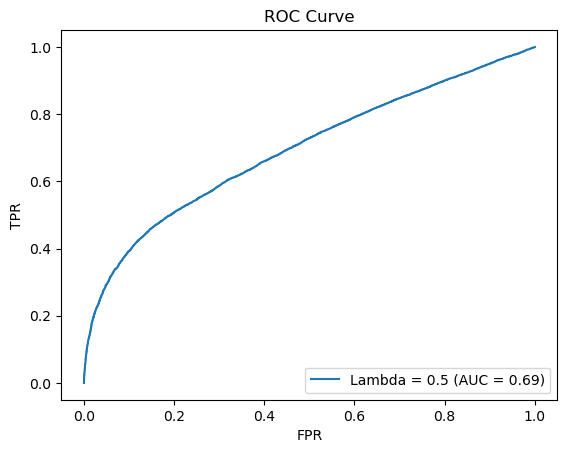

In [24]:
from analysis import calculate_auc
from visualize import plot_roc_curve
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(sig_lambda)] = fpr
tpr_dict[str(sig_lambda)] = tpr
auc_dict[str(sig_lambda)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")

# Test statistics

In [25]:
import analysis
import importlib
importlib.reload(analysis)
from analysis import Bootstrap_Permutation

In [26]:
bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)

In [27]:
lrt_null_bootstarp, auc_null_bootstarp, mce_null_bootstarp = bootstrap_permutation.bootstrap(1000)

100%|██████████| 1000/1000 [00:50<00:00, 19.84it/s]


In [28]:
lrt_null_permutation, auc_null_permutation, mce_null_permutation = bootstrap_permutation.permutation(1000)

100%|██████████| 1000/1000 [00:50<00:00, 19.77it/s]


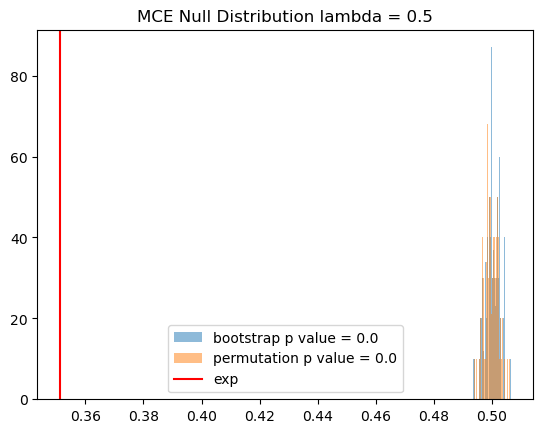

In [29]:
plt.hist(mce_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.mce_p_bootstrap))
plt.hist(mce_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.mce_p_permutation))
plt.axvline(bootstrap_permutation.mce_exp, color='r', label="exp")
plt.legend()
plt.title("MCE Null Distribution lambda = {}".format(sig_lambda))
plt.show()

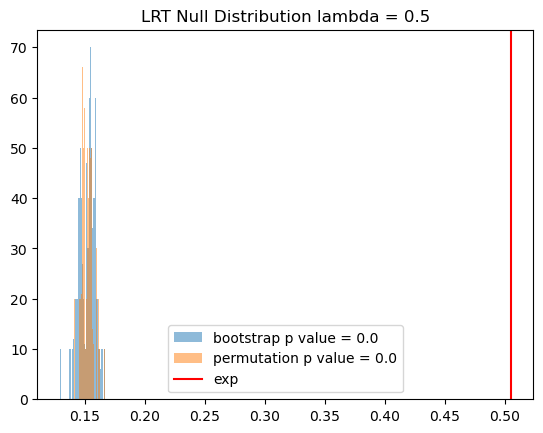

In [30]:
plt.hist(lrt_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.lrt_p_bootstrap))
plt.hist(lrt_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.lrt_p_permutation))
plt.axvline(bootstrap_permutation.lrt_exp, color='r', label="exp")
plt.legend()
plt.title("LRT Null Distribution lambda = {}".format(sig_lambda))
plt.show()

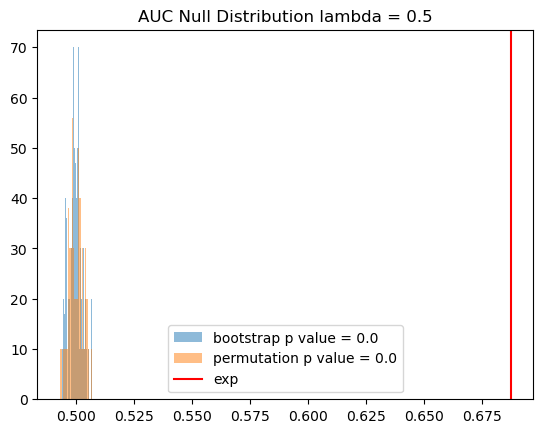

In [31]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.auc_p_bootstrap))
plt.hist(auc_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.auc_p_permutation))
plt.axvline(bootstrap_permutation.auc_exp, color='r', label="exp")
plt.legend()
plt.title("AUC Null Distribution lambda = {}".format(sig_lambda))
plt.show()

# Pull background null distribution

In [ ]:
from analysis import create_exp_null

In [ ]:
n = 100000
n_null = 1000

exp_events, bkg_events = create_exp_null(embedding_points['SM'], n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

hidden_dim = [8, 16, 16, 16, 8]
bkg_model = MLP(output_dim, hidden_sizes=hidden_dim)
bkg_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

train_model(
    bkg_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50,
    verbose=False
    )

bkg_null = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
_, _, _ = bkg_null.bootstrap(n_null, verbose=False)
_, _, _ = bkg_null.permutation(n_null, verbose=False)

# Estimate signal strength

In [32]:
from analysis import LambdaEstimator

estimated lambda: 0.5060553975333284
beta 0 = -0.18427769510115588, beta 1 = -0.5210542137370288
last bin height: 0.49394460246667166


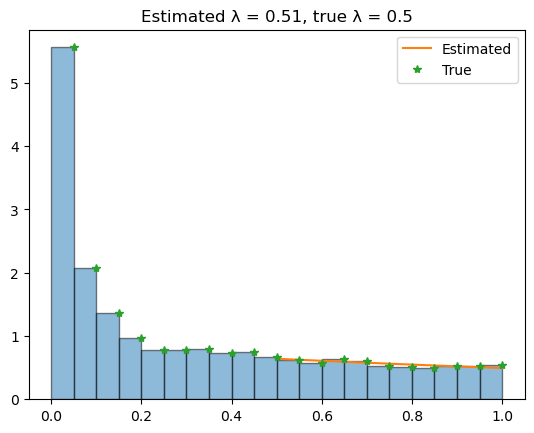

In [33]:
lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
print("estimated lambda:", lambda_estimator.estimated_lambda)
print("beta 0 = {}, beta 1 = {}".format(lambda_estimator.beta0, lambda_estimator.beta1))
print("last bin height:", lambda_estimator.estimated_H_t[-1])
plt.hist(lambda_estimator.rho_W, bins=lambda_estimator.bins, alpha=0.5, edgecolor='black', density=True)
start_idx = lambda_estimator.fit_start_idx
plt.plot(lambda_estimator.bins[start_idx:], lambda_estimator.estimated_H_t, label="Estimated")
plt.plot(lambda_estimator.bins[1:], lambda_estimator.H_t, '*',label="True")
plt.legend()
plt.title("Estimated λ = {:.2f}, true λ = {}".format(lambda_estimator.estimated_lambda, sig_lambda))
plt.show()

# Bootstrapped Uncertainty Intervals for λ

In [34]:
lambda_mean_dict = {}
lambda_std_dict = {}

lrt_p_permutation_dict = {}
lrt_p_bootstrap_dict = {}
auc_p_permutation_dict = {}
auc_p_bootstrap_dict = {}
mce_p_permutation_dict = {}
mce_p_bootstrap_dict = {}

In [35]:
import importlib
import classify
import analysis
importlib.reload(classify)
importlib.reload(analysis)
from classify import train_model
from analysis import Bootstrap_Permutation
opt_train_model  = torch.compile(train_model)

In [44]:
n_bootstrap = 10


test_ratio=0.2
val_ratio = 0.2
n = 100000
n_null = 1000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
significance = 0.05


test_lambdas = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for i in range(len(test_lambdas)):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_permutation_power = 0
    lrt_bootstrap_power = 0
    auc_permutation_power = 0
    auc_bootstrap_power = 0
    mce_permutation_power = 0
    mce_bootstrap_power = 0
    for j in range(n_bootstrap):
        exp_events, bkg_events = create_exp_bkg_events(embedding_points['SM'], embedding_points[test_signal], sig_lambda, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
        _, _, _ = bootstrap_permutation.bootstrap(n_null, verbose=False)
        _, _, _ = bootstrap_permutation.permutation(n_null, verbose=False)
        if bootstrap_permutation.lrt_p_permutation < significance:
            lrt_permutation_power += 1
        if bootstrap_permutation.lrt_p_bootstrap < significance:
            lrt_bootstrap_power += 1
        if bootstrap_permutation.auc_p_permutation < significance:
            auc_permutation_power += 1
        if bootstrap_permutation.auc_p_bootstrap < significance:
            auc_bootstrap_power += 1
        if bootstrap_permutation.mce_p_permutation < significance:
            mce_permutation_power += 1
        if bootstrap_permutation.mce_p_bootstrap < significance:
            mce_bootstrap_power += 1

        lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)
    lrt_p_permutation_dict[str(sig_lambda)] = lrt_permutation_power
    lrt_p_bootstrap_dict[str(sig_lambda)] = lrt_bootstrap_power
    auc_p_permutation_dict[str(sig_lambda)] = auc_permutation_power
    auc_p_bootstrap_dict[str(sig_lambda)] = auc_bootstrap_power
    mce_p_permutation_dict[str(sig_lambda)] = mce_permutation_power
    mce_p_bootstrap_dict[str(sig_lambda)] = mce_bootstrap_power


<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
sig_lambda: 0 estimated lambda mean: 0.007906653842744749 estimated lambda std: 0.012155170783703222
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_

In [ ]:
print(estimated_lambdas)
print(lambda_mean_dict)
print(lambda_std_dict)

[0.52509565 0.49158573 0.53438513 0.50716277 0.52628814 0.52704176
 0.53822071 0.51245938 0.51371156 0.52414501]
{'0': 0.008760449122745706, '0.01': 0.0013275525275852074, '0.05': 0.04704803637526868, '0.1': 0.09760295760819597, '0.2': 0.21171650978786277, '0.3': 0.3209293518848411, '0.4': 0.4171630945852886, '0.5': 0.520009584051379}
{'0': 0.01545288499245897, '0.01': 0.008403337477243577, '0.05': 0.00945412047843514, '0.1': 0.013586404358569719, '0.2': 0.014950091348389434, '0.3': 0.012262192590897107, '0.4': 0.01657743917018098, '0.5': 0.013903516060435384}


In [ ]:
import visualize
importlib.reload(visualize)
from visualize import plot_lambda

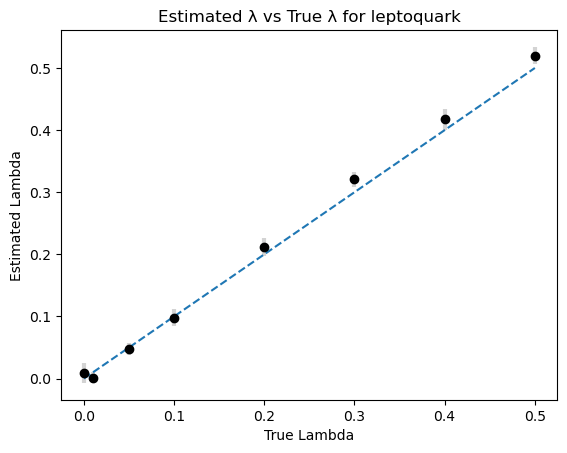

In [ ]:
plot_lambda(lambda_mean_dict, lambda_std_dict, test_signal)

In [ ]:
print(lrt_p_permutation_dict)
print(lrt_p_bootstrap_dict)
print(auc_p_permutation_dict)
print(auc_p_bootstrap_dict)
print(mce_p_permutation_dict)
print(mce_p_bootstrap_dict)

{'0': 0, '0.01': 1, '0.05': 10, '0.1': 10, '0.2': 10, '0.3': 10, '0.4': 10, '0.5': 10}
{'0': 0, '0.01': 2, '0.05': 10, '0.1': 10, '0.2': 10, '0.3': 10, '0.4': 10, '0.5': 10}
{'0': 1, '0.01': 0, '0.05': 10, '0.1': 10, '0.2': 10, '0.3': 10, '0.4': 10, '0.5': 10}
{'0': 0, '0.01': 2, '0.05': 10, '0.1': 10, '0.2': 10, '0.3': 10, '0.4': 10, '0.5': 10}
{'0': 9, '0.01': 2, '0.05': 10, '0.1': 10, '0.2': 10, '0.3': 10, '0.4': 10, '0.5': 10}
{'0': 9, '0.01': 2, '0.05': 10, '0.1': 10, '0.2': 10, '0.3': 10, '0.4': 10, '0.5': 10}


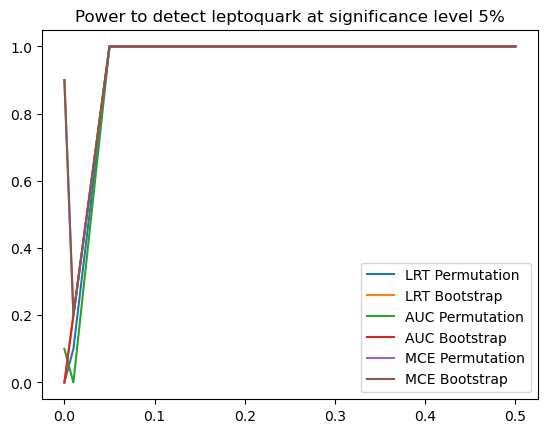

In [ ]:
plt.plot(test_lambdas, np.array([lrt_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Permutation")
plt.plot(test_lambdas, np.array([lrt_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Bootstrap")
plt.plot(test_lambdas, np.array([auc_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Permutation")
plt.plot(test_lambdas, np.array([auc_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Bootstrap")
plt.plot(test_lambdas, np.array([mce_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Permutation")
plt.plot(test_lambdas, np.array([mce_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Bootstrap")
plt.title("Power to detect {} at significance level {:.0%}".format(test_signal, significance))
plt.legend()
plt.show()

In [ ]:
import pandas as pd
power_df = pd.DataFrame(columns=test_lambdas)
power_df.loc["LRT Permutation"] = [lrt_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["LRT Bootstrap"] = [lrt_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Permutation"] = [auc_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Bootstrap"] = [auc_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Permutation"] = [mce_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Bootstrap"] = [mce_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

In [ ]:
display(power_df)

,0.00,0.01,0.05,0.10,0.20,0.30,0.40,0.50
LRT Permutation,0.0,0.1,1.0,1.0,1.0,1.0,1.0,1.0
LRT Bootstrap,0.0,0.2,1.0,1.0,1.0,1.0,1.0,1.0
AUC Permutation,0.1,0.0,1.0,1.0,1.0,1.0,1.0,1.0
AUC Bootstrap,0.0,0.2,1.0,1.0,1.0,1.0,1.0,1.0
MCE Permutation,0.9,0.2,1.0,1.0,1.0,1.0,1.0,1.0
MCE Bootstrap,0.9,0.2,1.0,1.0,1.0,1.0,1.0,1.0
